In [1]:
from os.path import expanduser
home = expanduser('~')
import numpy as np
import pandas as pd
from pymatgen.io.vasp.outputs import Eigenval, Outcar
import matplotlib.pyplot as plt

In [13]:
### Functions
def read_output(loc, template):

    ### Reading data
    for group, natoms in zip(groups, natoms_list):

        band_gaps = []
        mag_moms = []
        energies = []
        volumes = []
        des = []

        for var in indep_vars:

                suffix = template.format(group=group,var=var)

                ### Parsing output files
                out = Outcar(f'{loc}/OUTCAR-{suffix}')
                eig = Eigenval(f'{loc}/EIGENVAL-static-{suffix}', occu_tol=0.02)

                ### Energy
                out.read_pattern({"energy": "energy\(sigma->0\)\s+=\s+([\d\-\.]+)"}, 
                                 reverse=True, terminate_on_match=True)
                n_atoms = len(out.charge)
                energies.append(float(out.data['energy'][0][0])/n_atoms)
                
                ### Band gap
                band_gap = np.round(eig.eigenvalue_band_properties[0],3)
                # round down band gap due to ISMEAR=-5 negative occupancy errors
                if band_gap < 0.05:
                    band_gap = 0
                band_gaps.append(band_gap)
#                 print(f'\nBand gap = {np.round(eig.eigenvalue_band_properties[0],3)}')

                ### Magnetic details
                #  unique, counts = np.unique(np.round([mag["tot"] for mag in out.magnetization[8:16]], 2), return_counts=True); print(f'{np.asarray((unique,counts)).T}') 
                co_indices = (int(n_atoms/4), int(n_atoms/2))
                mag_mom = np.mean(np.abs([np.round(mag["tot"],3) for mag in out.magnetization[co_indices[0]:co_indices[1]]])) # Average moment
                mag_moms.append(mag_mom)

                ### Volume
                out.read_pattern({"volume": "volume of cell :\s+(\d+\.\d+)*"}, 
                                 reverse=True, terminate_on_match=True)
                volumes.append(float(out.data['volume'][0][0]))

        prop_dict.update({(group, 'indep_var') : indep_vars})
        prop_dict.update({(group, 'e_per_atom') : energies})
        prop_dict.update({(group, 'band_gap') : band_gaps})
        prop_dict.update({(group, 'mag_mom') : mag_moms})
        prop_dict.update({(group, 'volume') : volumes})
#         prop_dict.update({(group, 'v_per_atom') : [v/natoms for v, natoms in zip(volumes, natoms_list)]})
        prop_dict.update({(group, 'de_per_atom') : 1000*(np.array(energies)-np.array(prop_dict[groups[0],'e_per_atom'][0]))})
            
#     print(prop_dict)
    df = pd.DataFrame(prop_dict)
#     print(df[groups[0]]['e_per_atom'])
    
    ### Energy relative to P4/nmm
#     for group in groups:
#     df['de_per_atom'] = [df[group]['e_per_atom'] - df[groups[0]]['e_per_atom'] for group in groups]
    
    return df


def plot_var(prefix, df, dep_var, axis_label, labels, xlims=[None,None], ylims=[None,None]):
    
    fig = plt.figure(figsize=(6.5,2.4))
#     print(df[groups[0]])
    x = df[groups[0]].indep_var
    
    markers = ['o', '^', 's', '+']
    
    for group, label, marker in zip(groups, labels, markers):
        y = df[group][dep_var]
        plt.plot(x, y, marker=marker, label=label)
    
    # Plot customization
#     plt.axvline(x=13, color='k', linestyle='--')
    plt.gca().xaxis.label.set_fontsize(LABEL_FONT)
    plt.gca().yaxis.label.set_fontsize(LABEL_FONT)
    plt.gca().tick_params(labelsize=LABEL_FONT)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Mode Amplitude ($\AA$)'); plt.ylabel(axis_label)

#     plt.legend(fancybox=True, framealpha=0.5, fontsize=LABEL_FONT-2, ncol=3) 
    plt.legend(loc=(0.1,1.01), ncol=4, fontsize=LABEL_FONT-2) 

    # dep_var-dependent customization   
    if dep_var == 'de_per_atom':
        plt.axhline(y=0, color='k', linestyle='-')
    
    if dep_var == 'volume':
        plt.axhline(y=748.2, color='k', linestyle=':')
        
    if dep_var == 'v_per_atom':
        plt.axhline(y=748.2/32, color='k', linestyle=':')
        
#     if dep_var == 'band_gap':
#         plt.axhline(y=0.23, color='k', linestyle=':') 
        
    plt.xlim(xlims); plt.ylim(ylims)
    plt.show()

    # Saving plot
    fig.savefig(f'{prefix}_{dep_var}.png', bbox_inches='tight', dpi=400)
    
# def plot_eqn_of_state(df):
#     fig = plt.figure(figsize=(4.42,3))
    
#     for group in groups:
#         x = df[group]['volume']
#         y = df[group]['e_per_atom']
#         plt.plot(x, y, 'o-', label=group, clip_on=False)
        
#         # Plot customization
#         plt.gca().xaxis.label.set_fontsize(LABEL_FONT)
#         plt.gca().yaxis.label.set_fontsize(LABEL_FONT)
#         plt.gca().tick_params(labelsize=LABEL_FONT)
#         plt.legend()
#         plt.grid(True)
#         plt.xlabel('Volume ($\AA^3$)'); plt.ylabel('Energy (eV/atom)')
#         plt.legend(loc=(0,1.01), ncol=3, fontsize=LABEL_FONT-2) 

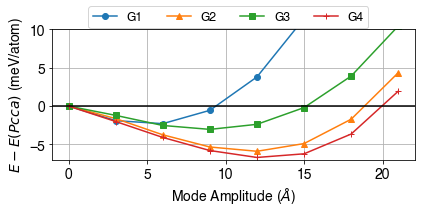

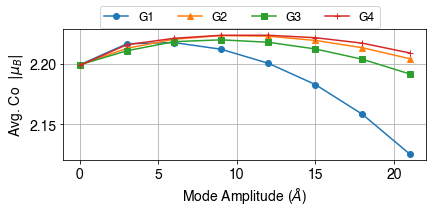

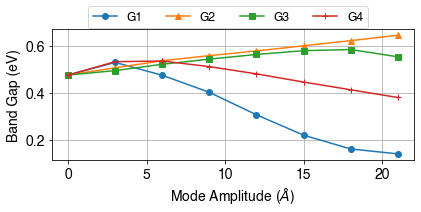

In [7]:
### Settings
prop_dict = {}
indep_vars = [0, 3, 6, 9, 12, 15, 18, 21]
natoms_list = [16,16,16,16]

groups = ['G1', 'G2', 'G3', 'G4']
iv_labels = groups

LOC = home + '/Projects/Raman-IR-BaCoS2/mod-path'
LABEL_FONT = 14

### Variables to plot
variables = ['de_per_atom', 'mag_mom', 'band_gap']#, 'v_per_atom', 'mag_mom']

axis_label_dict = {'de_per_atom' : '$E-E(Pcca)$ (meV/atom)', 'e_per_atom' : 'Energy (eV/atom)', 
                   'band_gap' : 'Band Gap (eV)', 'mag_mom' : 'Avg. Co  $|\mu_B|$', 
                   'v_per_atom' : 'Volume/atom ($\AA^3$)', 'e_per_atom' : '$E$ (meV/atom)'}

ylim_dict = {'de_per_atom' : [-7, 10],
             'e_per_atom' : [None, None],
             'band_gap' : [None, None], 
             'mag_mom' : [None, None], 
             'v_per_atom' : [None, None]}

df = read_output(LOC,  f'Pcca_U2-{group}-disp{var}')
# df

for var in variables:
    plot_var('Pcca-mod-path', df, var, axis_label_dict[var], iv_labels, ylims=ylim_dict[var]) 

In [8]:
### Settings
prop_dict = {}
indep_vars = [0, 12]
natoms_list = [16,16,16,16]

groups = [0, 0.5, 1, 1.5, 2]
iv_labels = groups

LOC = home + '/Projects/Raman-IR-BaCoS2/mod-path'
LABEL_FONT = 14

### Variables to plot
variables = ['de_per_atom', 'mag_mom', 'band_gap']#, 'v_per_atom', 'mag_mom']

axis_label_dict = {'de_per_atom' : '$E-E(Pcca)$ (meV/atom)', 'e_per_atom' : 'Energy (eV/atom)', 
                   'band_gap' : 'Band Gap (eV)', 'mag_mom' : 'Avg. Co  $|\mu_B|$', 
                   'v_per_atom' : 'Volume/atom ($\AA^3$)', 'e_per_atom' : '$E$ (meV/atom)'}

ylim_dict = {'de_per_atom' : [-7, 10],
             'e_per_atom' : [None, None],
             'band_gap' : [None, None], 
             'mag_mom' : [None, None], 
             'v_per_atom' : [None, None]}

# df = read_output('struc', LOC)
df = read_output(LOC, f'Pcca_U2-{group}-disp{var}')
# df


for var in variables:
    plot_var('Pcca-G4-U', df, var, axis_label_dict[var], iv_labels, ylims=ylim_dict[var]) 

FileNotFoundError: [Errno 2] No such file or directory: '/home/kyledmiller/Projects/Raman-IR-BaCoS2/mod-path/OUTCAR-Pcca_U2-0-disp0'

In [12]:
variable = 42
user_input = "The answer is {variable}"
formatted = user_input.format(variable=variable)
print(formatted)

The answer is 42
